## Principal Components Analysis and Final Model Selection
(Jupyter Notebook 3 of 3)

#### -------- Section 5:  Apply principal components analysis --------------------------------
Seven principal components (down from 36 + 1 original features) accounts for over 96% of the data variance!

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.utils import class_weight

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
# Load in the data saved previously in the "Data Loading" notebook #
# Elements are [X_trainraw, y_trainraw, X_testraw, y_testraw, terrain_labels].
import pickle

with open('data/dataframes_raw_20181023.pkl', 'rb') as picklefile: 
    raw_data = pickle.load(picklefile)

X_trainraw = raw_data[0]; y_trainraw = raw_data[1]
X_testraw = raw_data[2]; y_testraw = raw_data[3]
terrain_labels = raw_data[4]

In [6]:
# Normalize the data #
X_mean = X_trainraw.mean()   # save feature mean to run on test data later
X_trainnorm = X_trainraw - X_mean

In [7]:
from sklearn.decomposition import PCA

pca_func = PCA(n_components=37)
pca_func.fit(X_trainnorm)
# X_trainpca = pca_func.fit_transform(X_trainnorm)

PCA(copy=True, iterated_power='auto', n_components=37, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

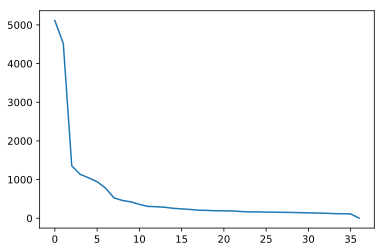

In [9]:
# Look at the singular values (ordered from highest to lowest) #
pca_svalues = pca_func.singular_values_
plt.plot(pca_svalues)

In [14]:
# Keep the first seven components, accounting for 96.8 of the variance #
pca_func = PCA(n_components=7)
X_trainpca = pca_func.fit_transform(X_trainnorm)  # a "whitened" scaled version was tried as well, w/ similar result

sum(pca_func.explained_variance_ratio_)

0.96816724302189328

###### -------- Section 6:  Re-evaluate the classifier models on the principal components  --------------------------------
Observed comparable performance of the Random Forest and KNN with PCA features

Result: Given the improvement in speed, going with the Random Forest.

In [69]:
# Import utility functions for scoring and displaying data #
import ClassAnalysis
import importlib
importlib.reload(ClassAnalysis)
from ClassAnalysis import plot_confusion_matrix, report_scores, accuracy_weighted

# Set up accuracy scoring to account for imbalance of class distribution #
nclasses = y_trainraw.nunique()
weights = class_weight.compute_class_weight('balanced', list(range(1,nclasses+1)), y_trainraw)

scorer = make_scorer(accuracy_weighted, class_weights=weights)

# Pre-compute stratified folds for the cross-validation #
ksplits = StratifiedKFold(n_splits=10, random_state=42)

In [26]:
# Set up KNN model #
model = KNeighborsClassifier()
grid_values = {'n_neighbors': [1] + list(range(2, 21, 2)), 'weights': ['uniform','distance']}
scorer = make_scorer(accuracy_weighted, class_weights=weights)

In [28]:
# Run the model and print results #
# Best parameters for rdm=42 are weighting = UNIFORM and # neighbors = 8. Weighted accuracy = 0.787. --> NOT BETTER!
grid_knn = GridSearchCV(model, cv=ksplits, param_grid=grid_values, scoring=scorer, n_jobs=-1)
grid_knn.fit(X_trainpca, y_trainraw);

print(grid_knn.best_estimator_)
print(grid_knn.best_params_)
print(grid_knn.best_score_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')
{'n_neighbors': 4, 'weights': 'uniform'}
0.823349348227


In [29]:
# Set up logistic regression model #
model = LogisticRegression(random_state=42, solver='newton-cg')
grid_values = {'penalty': ['l2'],'C': np.logspace(-4, 1, 6),
        'multi_class': ['ovr']}
scorer = make_scorer(accuracy_weighted, class_weights=weights)

In [30]:
# Run the model and print results (identical to above) #
# Best parameters for rdm=42 are penalty = L2 and C = 10. Weighted accuracy = 0.728. --> NOT BETTER!
grid_lr = GridSearchCV(model, cv=ksplits, param_grid=grid_values, scoring=scorer, n_jobs=-1)
grid_lr.fit(X_trainpca, y_trainraw);

print(grid_lr.best_estimator_)
print(grid_lr.best_params_)
print(grid_lr.best_score_)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)
{'C': 10.0, 'multi_class': 'ovr', 'penalty': 'l2'}
0.72815960626


In [31]:
# Set up random forest model #
model = RandomForestClassifier(random_state=42)
grid_values = {'n_estimators': np.array([25,50,75,100]),'max_features': np.linspace(0.2,1.0,5)}
scorer = make_scorer(accuracy_weighted, class_weights=weights)

In [32]:
# Run the model and print results (identical to above) #
# Best parameters for rdm=42 are n_estimators = 25 and max_features = 50%. Weighted accuracy = 0.830. --> NOT BETTER!
grid_rf = GridSearchCV(model, cv=ksplits, param_grid=grid_values, scoring=scorer, n_jobs=-1)
grid_rf.fit(X_trainpca, y_trainraw);

print(grid_rf.best_estimator_)
print(grid_rf.best_params_)
print(grid_rf.best_score_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.60000000000000009,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)
{'max_features': 0.60000000000000009, 'n_estimators': 100}
0.83098281839


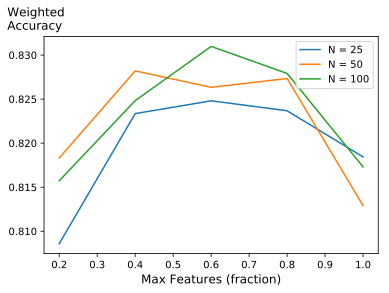

In [43]:
# Plot the results of the CV search #
cv_test_scores = grid_rf.cv_results_['mean_test_score']
cv_params = grid_rf.cv_results_['params']

xx_sm, yy_sm = [], []
xx_md, yy_md = [], []
xx_lg, yy_lg = [], []
for p,y in zip(cv_params,cv_test_scores):
    if p['n_estimators']==25:
        xx_sm.append(p['max_features'])
        yy_sm.append(y)
    elif p['n_estimators']==50:
        xx_md.append(p['max_features'])
        yy_md.append(y)
    elif p['n_estimators']==100:
        xx_lg.append(p['max_features'])
        yy_lg.append(y)

plt.plot(xx_sm,yy_sm);
plt.plot(xx_md,yy_md);
plt.plot(xx_lg,yy_lg);

plt.xlabel('Max Features (fraction)', fontsize=12)
plt.ylabel('Weighted\nAccuracy', fontsize=12, rotation=0, ha='left')
plt.gca().yaxis.set_label_coords(-0.11,1.02)
plt.legend(['N = 25','N = 50','N = 100'],loc=1);

plt.savefig('supporting_files/RF_GridSearch_PCA.svg', dpi=300)

###### -------- Section 7:  Obtain a final fitting for the Random Forest model  --------------------------------
Result: Perfect classification on the 7-feature PC data!!  
The first 3 PCs have a much more weighted importance than the others.

In [44]:
# Refit the Random Forest model to the best parameters #
model = RandomForestClassifier(n_estimators=100, max_features = 0.1, random_state=42)
model.fit(X_trainpca, y_trainraw)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

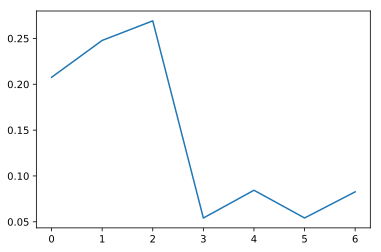

In [45]:
# Plot the importance of the features #
plt.plot(np.linspace(0,6,7), model.feature_importances_);

                precision    recall  f1-score   support

      red soil       1.00      1.00      1.00 739.1666666666731
   cotton crop       1.00      1.00      1.00 739.1666666666696
     grey soil       1.00      1.00      1.00 739.1666666666827
     damp soil       1.00      1.00      1.00 739.1666666666715
    vegetation       1.00      1.00      1.00 739.1666666666705
very damp soil       1.00      1.00      1.00 739.1666666666766

   avg / total       1.00      1.00      1.00 4435.000000000045



-- Metric ----- Training Data ----
 Accuracy:       1.000
 Precision:      1.000
 Recall:         1.000
 F1 Score:       1.000




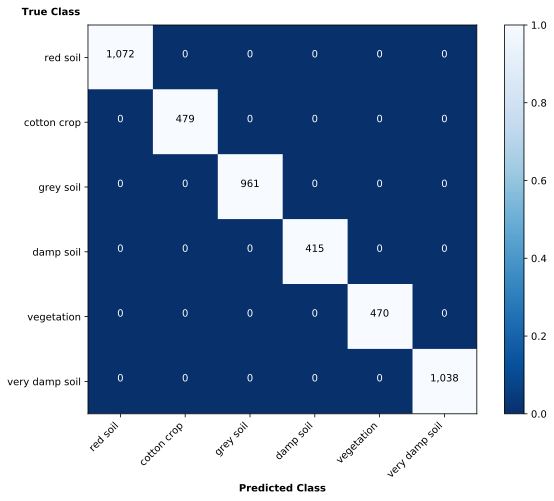

In [63]:
# Report the final training statistics #
ypred_trainclean = model.predict(X_trainpca);
cm_plt = report_scores(y_trainraw, ypred_trainclean, terrain_labels, 'balanced', 'Training Data');
cm_plt.savefig('supporting_files/CMat_TrainPCA.svg')

###### -------- Section 7:  Refine the fitting based on cost-benefit considerations --------------------------------
The idea here is that the false identifications of cotton crop should be penalized, and confusions among grey soil types tolerated.

In [54]:
# This function maps classifier probabilities to final class predictions #
def refine_predict(prob_vec, benefit_mat, cost_mat):
    ''' Return cost-benefit-adjusted prediction based on class probabilities.'''
    ben_vec = prob_vec.dot(benefit_mat)
    cost_vec = (1-prob_vec).dot(cost_mat)
    pred_vec = np.argmax(ben_vec-cost_vec, axis=1) + 1
    
    return pred_vec

In [55]:
# Define the mapping matrices. #
# Identity matrices would treat all classes with the same costs and benefits.
COST = np.eye(6);
COST[1,1]=3;                        # not-p-cotton gives extra penalty to "cotton"
BENEFIT = np.eye(6);
BENEFIT[1,4]=-2;                    # p-cotton suppresses "vegetation"
BENEFIT[2,3]=0.3; BENEFIT[2,5]=0.2  # for p-greysoil, allow confusions with other "grey soil" types
BENEFIT[3,2]=0.3; BENEFIT[3,5]=0.2; # for p-dampsoil, allow confusions with other "grey soil" types
BENEFIT[5,2]=0.2; BENEFIT[5,3]=0.3; # for p-verygreysoil, allow confusions with other "grey soil" types

print(BENEFIT, '\n\n', COST)

[[ 1.   0.   0.   0.   0.   0. ]
 [ 0.   1.   0.   0.  -2.   0. ]
 [ 0.   0.   1.   0.3  0.   0.2]
 [ 0.   0.   0.3  1.   0.   0.2]
 [ 0.   0.   0.   0.   1.   0. ]
 [ 0.   0.   0.2  0.3  0.   1. ]] 

 [[ 1.  0.  0.  0.  0.  0.]
 [ 0.  3.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.]]


                precision    recall  f1-score   support

      red soil       0.96      0.99      0.97     461.0
   cotton crop       1.00      0.91      0.95     224.0
     grey soil       0.81      0.95      0.87     397.0
     damp soil       0.55      0.48      0.51     211.0
    vegetation       0.93      0.60      0.73     237.0
very damp soil       0.78      0.86      0.82     470.0

   avg / total       0.85      0.84      0.84    2000.0



-- Metric ----- Average Scores ----
 Accuracy:       0.843
 Precision:      0.839
 Recall:         0.798
 F1 Score:       0.810




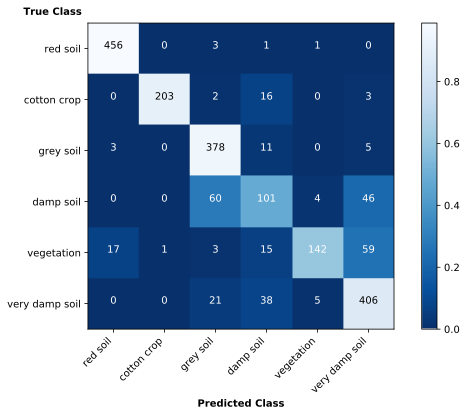

In [74]:
# Report final statistics on test data based on refined "cost-benefit" prediction #
# Note the different averaging techniques for the two sets of statistics (top=micro, bottom=macro). #
X_testnorm = X_testraw - X_mean                  # apply the PC transform to the test data
X_testpca = pca_func.fit_transform(X_testnorm)

yprob_testpca = model.predict_proba(X_testpca)   # don't weight the classes (because they'd be unknown w/ test set)
ypred_testpca_cb = refine_predict(yprob_testpca, BENEFIT, COST)
cm_plt = report_scores(y_testraw, ypred_testpca_cb, terrain_labels, None, 'Average Scores')

cm_plt.subplots_adjust(bottom=0.24, top=0.95)
ax = cm_plt.gca()
cm_plt.savefig('supporting_files/CMat_PCAcb.svg', dpi=300)

                precision    recall  f1-score   support

      red soil       0.96      0.98      0.97     461.0
   cotton crop       0.95      0.98      0.96     224.0
     grey soil       0.82      0.95      0.88     397.0
     damp soil       0.64      0.44      0.52     211.0
    vegetation       0.86      0.66      0.75     237.0
very damp soil       0.79      0.86      0.82     470.0

   avg / total       0.85      0.85      0.84    2000.0



-- Metric ----- Average Scores ----
 Accuracy:       0.851
 Precision:      0.836
 Recall:         0.811
 F1 Score:       0.817




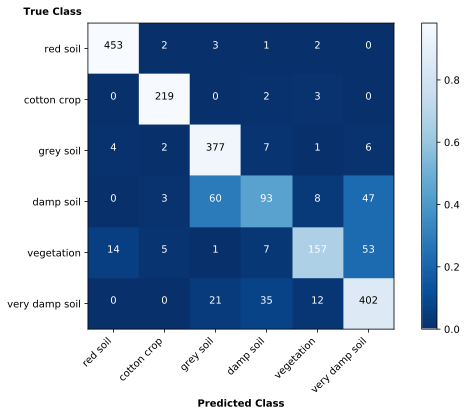

In [75]:
# Here's the final prediction WITHOUT the cost-benefit adjustment #
ypred_testpca = model.predict(X_testpca)   # don't weight the classes (because they'd be unknown w/ test set)
cm_plt = report_scores(y_testraw, ypred_testpca, terrain_labels, None, 'Average Scores')

cm_plt.subplots_adjust(bottom=0.24, top=0.95)
ax = cm_plt.gca()
cm_plt.savefig('supporting_files/CMat_PCA.svg', dpi=300)